In [63]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [64]:
training_dataset_path = "./10monkeys/training/training"
test_dataset_path = "./10monkeys/validation/validation"

In [65]:
# could import the get_mean_and_std function here instead
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2037]

In [66]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [67]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=test_transforms)

In [68]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels: ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0857832..3.2935688].


labels:  tensor([6, 6, 9, 4, 1, 1])


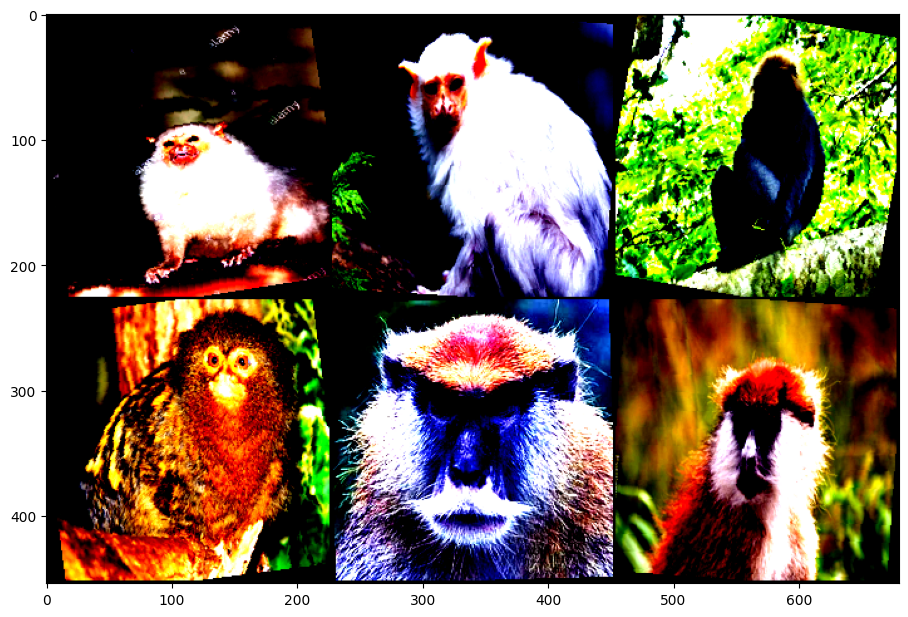

In [69]:
show_transformed_images(train_dataset)

In [70]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [71]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

CUDA is available.
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4080 SUPER


In [72]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [73]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0

    for epoch in range(n_epochs):
        print("Epoch Number %d " % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print("    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
        % (running_correct, total, epoch_acc, epoch_loss))

        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)

        if (test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)

    print("Finished")
    return model

In [74]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    
    print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
        % (predicted_correctly_on_epoch, total, epoch_acc))
    
    return epoch_acc



In [75]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        "epoch" : epoch + 1,
        "model" : model.state_dict(),
        "best accuracy" : best_acc,
        "optimizer" : optimizer.state_dict(),
        "comments" : "current best model",
    }
    torch.save(state, "model_best_checkpoint.pth.tar")

In [76]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=True)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_19_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

/home/etharialle/venv/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etharialle/venv/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 10)

Epoch Number 1 
    - Training dataset. Got 841 out of 1097 images correctly (76.664%). Epoch loss: 0.690
    - Testing dataset. Got 250 out of 272 images correctly (91.912%)
Epoch Number 2 
    - Training dataset. Got 1068 out of 1097 images correctly (97.356%). Epoch loss: 0.078
    - Testing dataset. Got 252 out of 272 images correctly (92.647%)
Epoch Number 3 
    - Training dataset. Got 1084 out of 1097 images correctly (98.815%). Epoch loss: 0.048
    - Testing dataset. Got 266 out of 272 images correctly (97.794%)
Epoch Number 4 
    - Training dataset. Got 1088 out of 1097 images correctly (99.180%). Epoch loss: 0.041
    - Testing dataset. Got 266 out of 272 images correctly (97.794%)
Epoch Number 5 
    - Training dataset. Got 1085 out of 1097 images correctly (98.906%). Epoch loss: 0.061
    - Testing dataset. Got 267 out of 272 images correctly (98.162%)
Epoch Number 6 
    - Training dataset. Got 1087 out of 1097 images correctly (99.088%). Epoch loss: 0.033
    - Testing 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
checkpoint = torch.load("model_best_checkpoint.pth.tar")

/tmp/ipykernel_6061/1743052654.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_best_checkpoint.pth.tar")


In [79]:
print(checkpoint["epoch"])
print(checkpoint["comments"])
print(checkpoint["best accuracy"])

10
current best model
98.52941176470588
